In [1]:
import scipy.integrate as spi
import numpy as np
import math
import sympy
from sympy import *
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
#if 1+w>1/r,that means vaccinated infected individuals have more cost than unvaccinated infected 
mu=1
gamma1=0.3
gamma2=0.6
eff=0.25
w=0.5
#1-w=0.8
V=5
C=9.5
r=C/V
#r=C/V,1/r=V/C=1/2
Timescale=0.01
beta=7
S1_average_list=[]
S2_average_list=[]
I1_average_list=[]
I2_average_list=[]
R_average_list=[]
x_average_list=[]
ex_average_list=[]
f1_list=[]
f2_list=[]
list1=[]
list2=[]
x_solve_list=[]
R11_list=[]
R22_list=[]
x_solve_list=[]
alpha_list=np.arange(0.0,1.01,0.05)
theta_list=np.arange(0.0,1.01,0.05)
#theta_list=theta_list[::-1]
x_at_list=np.empty([len(alpha_list),len(theta_list)])
x_solve_at_list=np.empty([len(alpha_list),len(theta_list)])
I1_FDE=np.empty([len(alpha_list),len(theta_list)])
I2_FDE=np.empty([len(alpha_list),len(theta_list)])
FDE=np.empty([len(alpha_list),len(theta_list)])
cost_curing=np.empty([len(alpha_list),len(theta_list)])
cost_vaccinating=np.empty([len(alpha_list),len(theta_list)])
cost_sum=np.empty([len(alpha_list),len(theta_list)])
#print(x_ew_list)
#print(eff_list)
i=-1
for alpha in alpha_list:
    i+=1
    j=-1
    for theta in theta_list:
        j+=1
        beta11=beta
        beta12=beta/(1+alpha)
        beta21=beta/(1+alpha)
        beta22=beta/((1+theta)*(1+alpha))
        R11=beta11/(gamma1+mu)
        R12=beta12/(gamma1+mu)
        R21=beta21/(gamma2+mu)
        R22=beta22/(gamma2+mu)
        p=1-1/(r*(1-w*(1-eff)))
#game dynamic
#x*(1-x)*((f-w*(1-e)f)C-V)
        TS=1
        ND=10000
        #set initial value
        x0=0.1
        S10=1-x0
        S20=(1-eff)*x0
        I10=0.01
        I20=0.01
        R0=1-S10-S20-I10-I20
    #S1=V[0],S2=V[1],I1=V[2],I2=V[3],R=V[4],X=V[5]
    #print(Rf1,Rf2,R0,1/(1-eff))
    #print(1/(p*(1-eff)),R0,1/p)
        #calculate the fixed point of approximate system
        if p<0 or p==0:
            x_solve=0
        elif p>0 and R11<1/p:
            x_solve=0
        elif p>0 and R11>1/p and R22<1/(p*(1-eff)):
            x ,a,b,c,d= symbols('x,a,b,c,d')
            #p=1-1/(r*(1-w*(1-eff)))
            a=beta11*(1-x)/(gamma1+mu)
            b=beta21*(1-x)/(gamma2+mu)
            c=beta12*(1-eff)*x/(gamma1+mu)
            d=beta22*(1-eff)*x/(gamma2+mu)
            eq_exp =a/2+d/2+((a**2+d**2-2*a*d+4*b*c)**(1/2))/2 -1/p
            x_solve= solve(eq_exp, x)[0]    
        elif p>0 and R22>1/(p*(1-eff)):
            x_solve=1
        else:
            x_solve=100
        INPUT = (S10,S20,I10,I20,R0,x0)
        def diff_eqs(INP,t):
            Y=np.zeros((6))
            VAR = INP
    #I2star
    #k1=(1-eff*VAR[5]-((gamma2+mu)/(beta*(gamma2+mu)/(gamma1+mu)*(1-VAR[5])/((1-eff)*VAR[5]) +beta))*(1-eff*VAR[5])/((1-eff)*VAR[5]))
    #k2=1+(1-VAR[5])/((1-eff)*VAR[5])*(gamma2+mu)/(gamma1+mu)+(gamma1*(1-VAR[5])/((1-eff)*VAR[5])*(gamma2+mu)/(gamma1+mu)+gamma2 )/mu
    #I2star=k1/k2
    #I1star
    #I1star= I2star*(1-VAR[5])/((1-eff)*VAR[5])*(gamma2+mu)/(gamma1+mu)
    
    #xh=(gamma2+mu-beta*(gamma2+mu)/(gamma1+mu))/(beta*(1-eff-(gamma2+mu)/(gamma1+mu)))
            Y[0] = mu*(1-VAR[5])-mu*VAR[0]-beta11*VAR[0]*VAR[2]-beta21*VAR[0]*VAR[3]
            Y[1] = mu*(1-eff)*VAR[5]-mu*VAR[1]-beta12*VAR[1]*VAR[2]-beta22*VAR[1]*VAR[3]
            Y[2] = beta11*VAR[0]*VAR[2]+beta21*VAR[0]*VAR[3]-gamma1*VAR[2]-mu*VAR[2]
            Y[3] = beta12*VAR[1]*VAR[2]+beta22*VAR[1]*VAR[3]-gamma2*VAR[3]-mu*VAR[3]
            Y[4] = mu*eff*VAR[5]+gamma1*VAR[2]+gamma2*VAR[3]-mu*VAR[4]
            Y[5] = Timescale*VAR[5]*(1-VAR[5])*((1-mu/(beta11*VAR[2]+beta21*VAR[3]+mu)-w*(1-eff)*(1-mu/(beta12*VAR[2]+beta22*VAR[3]+mu)))*C-V)
            return Y
        t_range = np.arange(0.0, ND+TS, TS) 
    #odeint
        RES = spi.odeint(diff_eqs,INPUT,t_range)
    #infection risk
        f1=1-mu/(beta11*RES[-1,2]+beta21*RES[-1,3]+mu)
        f2=1-mu/(beta12*RES[-1,2]+beta22*RES[-1,3]+mu)
    #print(f1,f2)
        S1_average=np.mean(RES[-500:-1,0])
        S2_average=np.mean(RES[-500:-1,1])
        I1_average=np.mean(RES[-500:-1,2])
        I2_average=np.mean(RES[-500:-1,3])
        R_average=np.mean(RES[-500:-1,4])
        x_average=np.mean(RES[-500:-1,5])
        ex_average=x_average*eff
        S1_average_list.append(S1_average)
        S2_average_list.append(S2_average)
        I1_average_list.append(I1_average)
        I2_average_list.append(I2_average)
        R_average_list.append(R_average)
        x_average_list.append(x_average)
        ex_average_list.append(ex_average)
        f1_list.append(f1)
        f2_list.append(f2)
        R11_list.append(R11)
        R22_list.append(R22)
        list1.append(1/(p*(1-eff)))
        list2.append(1/p)
        x_solve_list.append(x_solve)
        x_at_list[i][j]=x_average
        x_solve_at_list[i][j]=x_solve
        I1_FDE[i][j]=I1_average
        I2_FDE[i][j]=I2_average
        FDE[i][j]=I1_average+I2_average
        cost_curing[i][j]=(I1_average+w*I2_average)*C
        cost_vaccinating[i][j]=x_average*V
        cost_sum[i][j]=x_average*V+(I1_average+w*I2_average)*C
    #print(1/(p*(1-eff)),R0,1/p,x_average,x_solve)
    #print(x_star_d1)
        #print(I1_average,I2_average)
#print(x_average_list,ex_average_list,eff_list)


In [2]:
data_result_list=np.array([x_at_list])
data_result_name_list=np.array(['x_at_list'])

In [3]:
#data_result_list=np.array([x_at_list,I1_FDE,I2_FDE,FDE,cost_curing,cost_vaccinating,cost_sum])
#data_result_name_list=np.array(['x_at_list','I1_FDE','I2_FDE','FDE','cost_curing','cost_vaccinating','cost_sum'])

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



In [5]:
alpha_list=[0,'',0.1,'' ,0.2 , '', 0.3 ,'',0.4 ,'',0.5 ,'',0.6,'',0.7,'',0.8,'',0.9 ,'', 1]
#alpha_list=alpha_list[::-1]
theta_list=[0,'',0.1,'' ,0.2 , '', 0.3 ,'',0.4 ,'',0.5 ,'',0.6,'',0.7,'',0.8,'',0.9 ,'', 1]

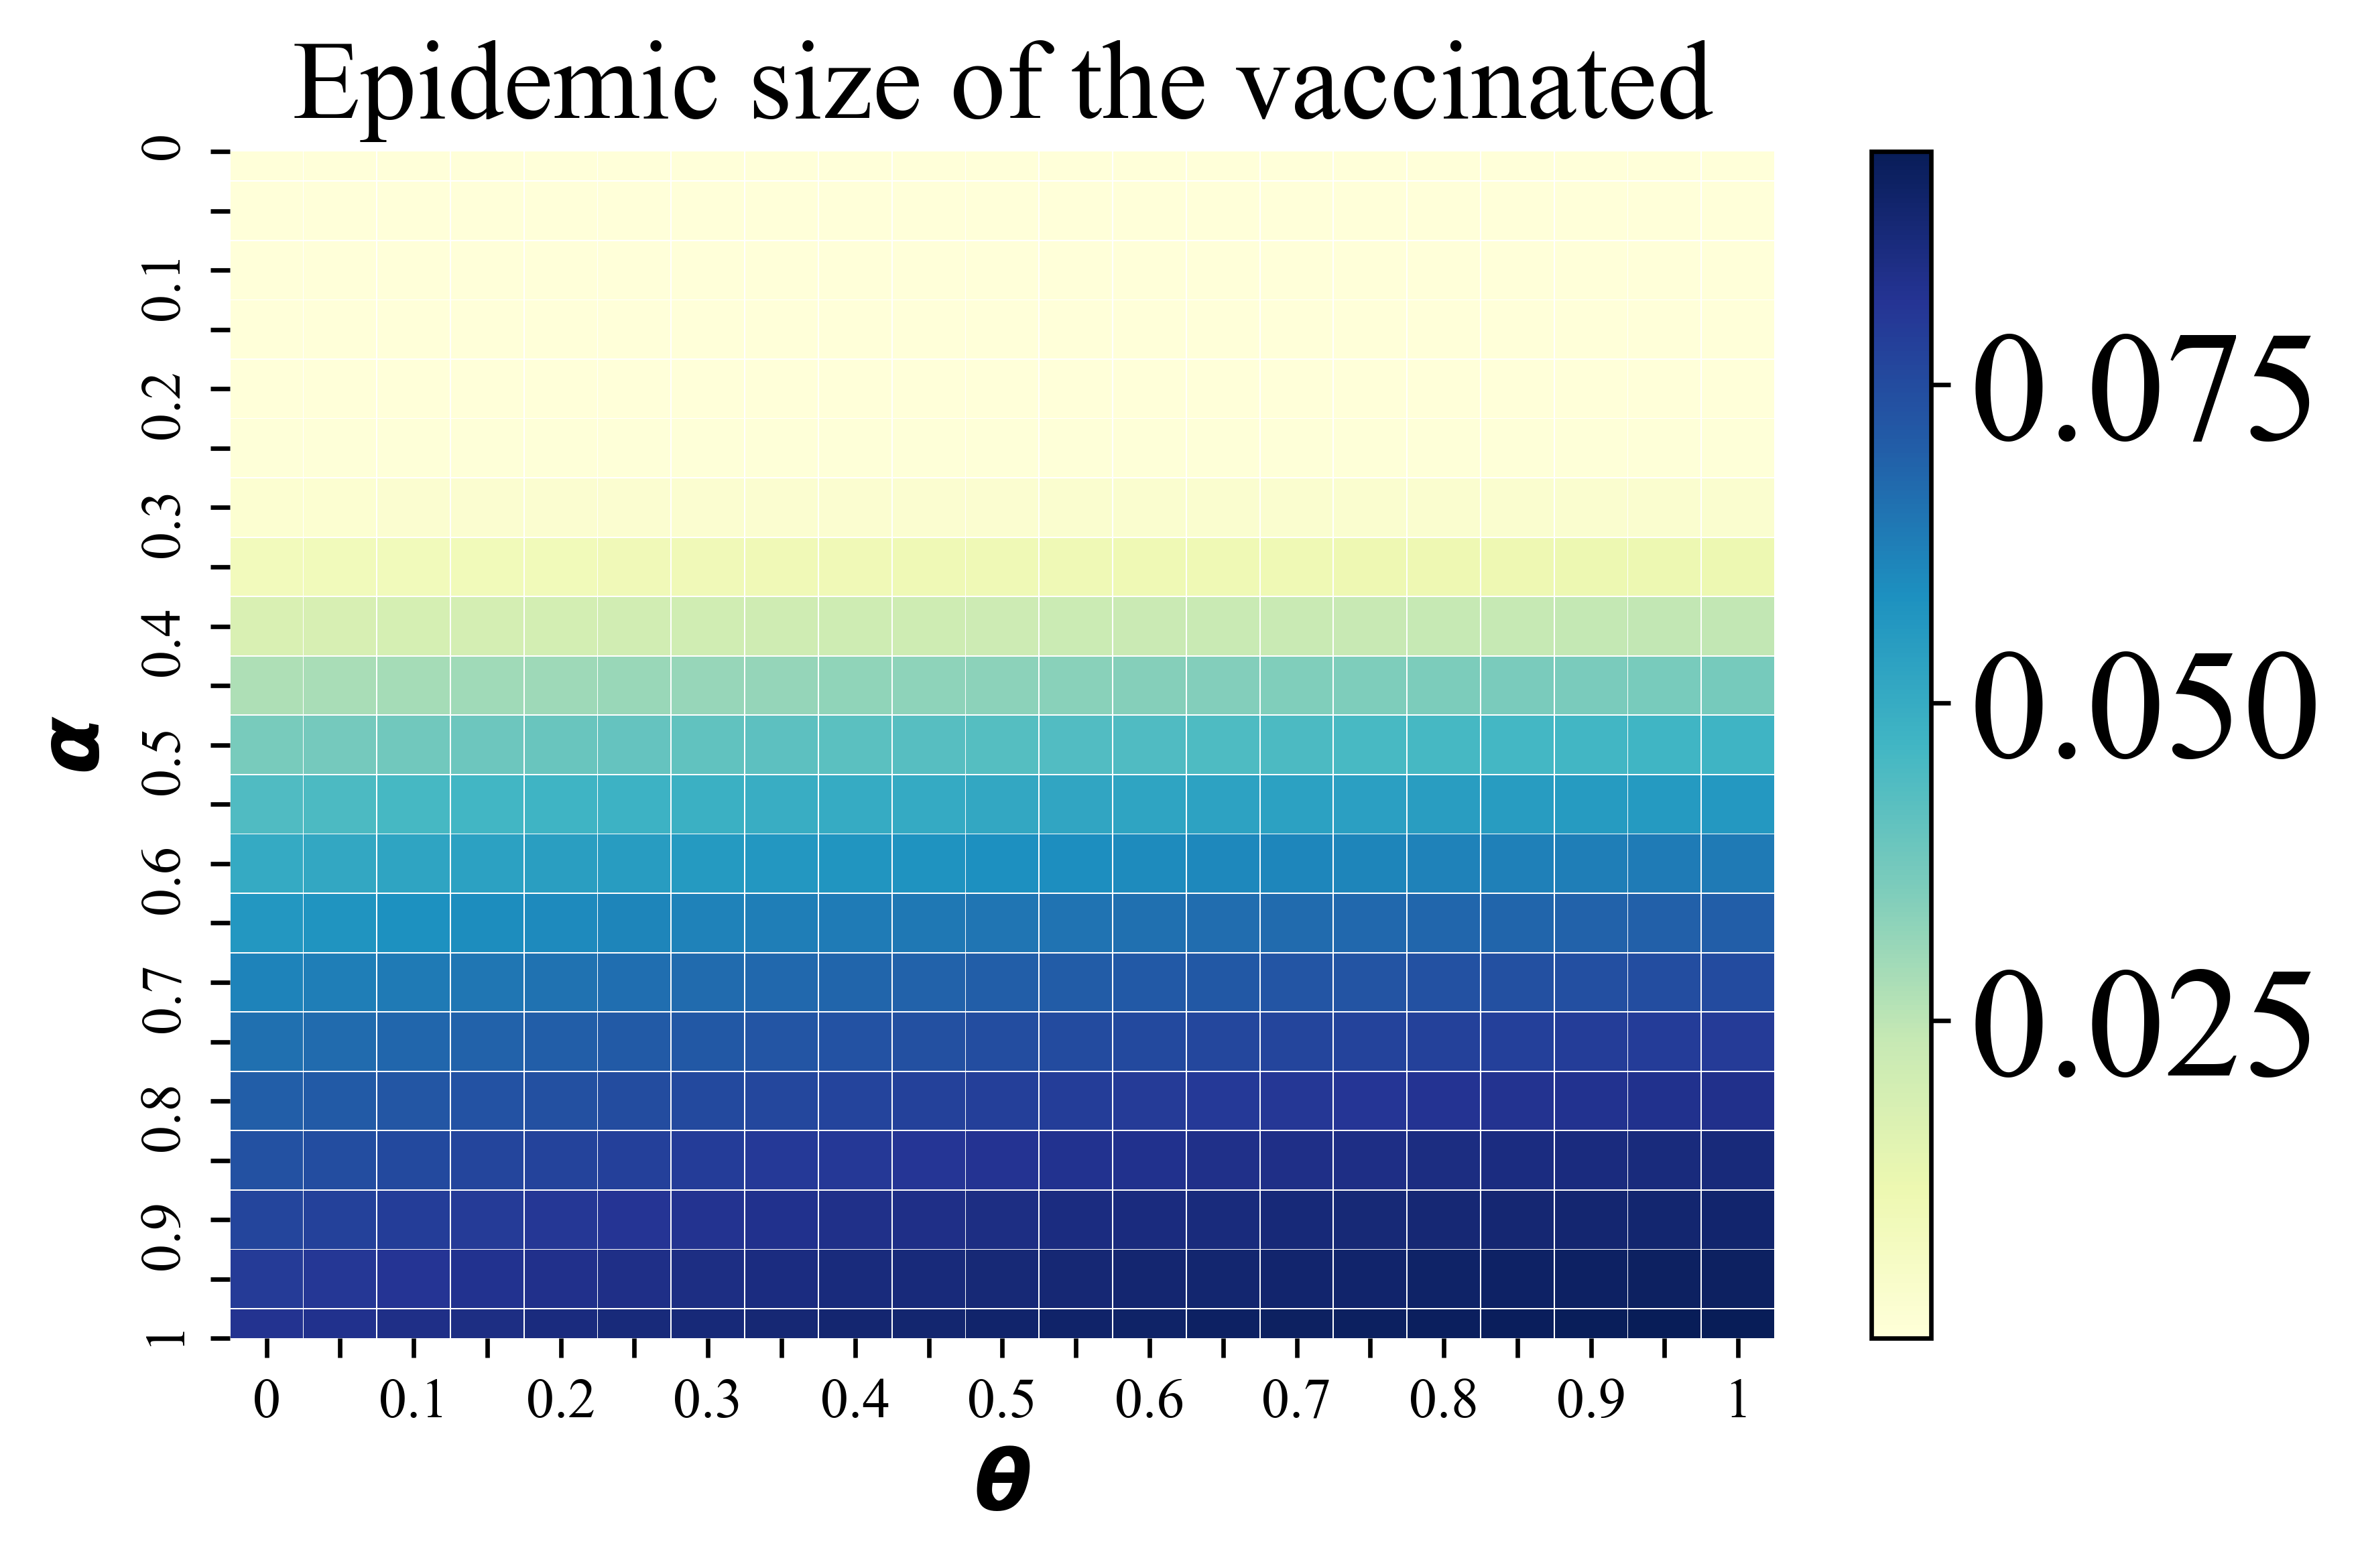

In [14]:
plt.rc('font', family='Times New Roman')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
h = sns.heatmap(data=I2_FDE, 
    cmap='YlGnBu',linewidths=.1,
                annot=False,  
                cbar=False,
                vmax=np.max(I2_FDE),
                vmin=np.min(I2_FDE),
                yticklabels=alpha_list,
                xticklabels=theta_list,)
cb = h.figure.colorbar(h.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=28) 
plt.title('Epidemic size of the vaccinated', fontsize=20) # 'WS(m/s)'  u'T(°C)'  'P(mbar)'
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] =600 
plt.tight_layout()

#plt.show()
plt.savefig(file_path  = r'E:',fname='figure9_2.jpg')